# 3 Logsitic Regression

## Logistic Regression

If $x\in\mathbb R^p$ are covariates while the response $y\in\{0,1\}$, we can no longer use the method of linear regression since the linear regression outputs unbound predictions.

We can modify the linear regression by composing a bounded function,
$$P(Y=1|X=x) =  \frac{1}{1+\exp (-x^T\beta)}$$
while $P(Y=0|X=x)= 1-P(Y=1|X=x)$.

This is the logistic regression (逻辑回归).

We define the log-odds to be 
$$\log\frac{P(Y=1|x)}{P(Y=0|x)} = x^T\beta.$$

The log-odds is linear. Actually the logistic regression is one of generalized linear models.

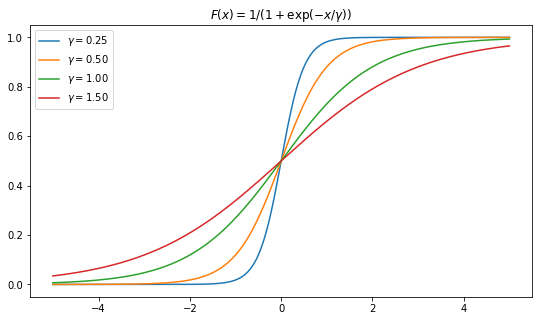

In [2]:
from matplotlib import pyplot as plt 
import numpy as np 
x = np.linspace(-5, 5, 200)
gammas = (.25, .5, 1., 1.5)
plt.figure(figsize = (9, 5))
for gamma in gammas:
    plt.plot(x, 1. / (1. + np.exp(-x/gamma)))
plt.legend(['$\\gamma=%.2f$'%gamma for gamma in gammas])
plt.title('$F(x) = 1 / (1 + \\exp(-x/\\gamma))$')
plt.show()

## Model Estimation

Given many data $(x_i,y_i)$ where $x_i\in\mathbb R$ and $y_i\in\{0,1\}$, we eager to find the value of parameter $\beta$ in the logisitic regression model. This can be done by using maximum likelihood estimator, which is given by

$$\begin{aligned}
\log L &= \log\left(\prod_{y_i=1}\frac{1}{1+\exp(-x_i^T\beta)}\prod_{y_i=0}\frac{\exp(-x_i^T\beta)}{1+\exp(-x_i^T\beta)}\right)
\\ &= \log\left(\prod_{y_i=1}\frac{\exp( x_i^T\beta)}{1+\exp( x_i^T\beta)}\prod_{y_i=0}\frac{1}{1+\exp(x_i^T\beta)}\right)
\\ &= \sum_{y_i=1}x_i^T\beta -\sum_{i=1}^n \log \left(1+\exp(x_i^T\beta)\right)
\end{aligned}$$

There does not exist closed form solution to the $\nabla \log L = 0$, indicating that we can only turn to numerical methods.

### Newton-Raphson Algorithm

As we know for sure that $-\log L$ has single minimum (and convex), we can use the Newton's algorithm to iterate, which is 
$$\beta_{k+1} = \beta_k -\left( \nabla^{2}\log L\right)^{-1}\nabla \log L.$$

If we denote $p_i = {1}/\left({1+\exp(-x_i^T\beta)}\right)$ and $W = {\rm diag}[p_i(1 - p_i)]$, then we can compute that 
$$\nabla \log L = X^T(y - p)
\quad\quad \nabla^2 \log L = - X^TWX.$$

Thus, 
$$\begin{aligned}\beta_{k+1}&=\beta_k + (X^TWX)^{-1}X^T(y - p)
=(X^TWX)^{-1}X^TW(X\beta_k+W^{-1}(y - p)).
\end{aligned}$$



In [3]:
import numpy as np
def logL(X, y, b):
    """Compute the log-likelihood of (X,y) with coefficient b in the logistic regression."""
    Xb = X @ b
    return np.sum(Xb * y) - np.sum(np.log(1. + np.exp(Xb)))

def LogisticRegression(X, y, verbose = 1, tol = 1e-5, maxiter = 40):
    """Solve logistic regression using Newton-Raphson algorithm. X shape = (N,k), y shape = (N,)"""
    b = np.zeros(X.shape[1])
    logl = logL(X, y, b)
    for i in range(maxiter):
        p = 1. / (1. + np.exp(-X @ b))
        W = (p * (1. - p)).reshape((-1,1))
        b += np.linalg.solve(X.T @ (W * X), X.T @ (y - p))
        new_logl = logL(X, y, b)
        if verbose and (i+1)%verbose == 0: print('Step %02d Log Likelihood ='%(i+1), new_logl)
        if abs(new_logl - logl) < tol: break
        logl = new_logl
    return b

# simulate data
N, k = 1000, 5
np.random.seed(20221018)
X = np.random.randn(N,k) # the data will be split in halves for training and validation 
real_b = np.random.randn(k) * 10
noise = np.random.randn(N) * .2 # WARN: if no noise, the alg is likely not to converge
y = ((1. / (1 + np.exp(-X @ real_b)) + noise) > 0.5).astype('float')
pred_b = LogisticRegression(X[:N//2], y[:N//2], verbose = 2, maxiter=30, tol = 1e-9)
print('\nReal    Log Likelihood =', logL(X[:N//2], y[:N//2], real_b))

# NOTE: High error is common (even > 100%), but the result is good -- accuracy is high
print('Error   = %.4f%%'%(np.linalg.norm(real_b - pred_b) / np.linalg.norm(real_b) * 100))
print('Val Acc = %.4f%%'%(((1. / (1 + np.exp(-X[N//2:] @ pred_b)) > .5) == y[N//2:].astype('bool')).mean()))

Step 02 Log Likelihood = -103.6623115185663
Step 04 Log Likelihood = -60.51534434572227
Step 06 Log Likelihood = -54.2202693918307
Step 08 Log Likelihood = -54.15783378379365
Step 10 Log Likelihood = -54.1578337776441

Real    Log Likelihood = -68.6983424998989
Error   = 48.9078%
Val Acc = 0.9820%



### Multinomial Logisitic Regression 

When $y_i\in\{1,2,\dotsc,K\}$, we can introduce $k$ parameters $\beta_j\ (j=1,2,\dotsc,K)$ and 
$$\mathbb P(Y = k|X = x) = \frac{\exp(\beta_k^T x)}{1+\sum_{j=1}^{K-1}\exp (\beta_j^T x)}
\quad (k = 1,2,\dotsc,K-1)$$
whilst $\mathbb P(Y = K|X =x ) = 1 - \sum_{j=1}^{K-1}\mathbb P(Y - j|X =x )$.

### Probit Regression


One can replace the $1/(1+\exp\{-\cdot\})$ term in logistic regression with other functions. For example, if one use the $\Phi$, the cummulative distribution function of normal distribution, then it is the [probit regression](https://en.wikipedia.org/wiki/Probit_model).

$$\mathbb P(Y = 1|X = x) = \Phi(X^T\beta).$$

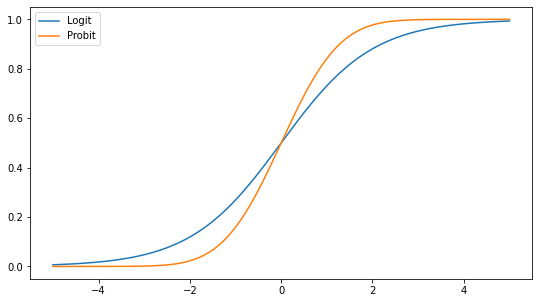

In [4]:
from matplotlib import pyplot as plt
from scipy.stats import norm
x = np.linspace(-5, 5, 200)
y_logistic = 1. / (1. + np.exp(-x))
y_probit   = norm.cdf(x)
plt.figure(figsize = (9, 5))
plt.plot(x, y_logistic)
plt.plot(x, y_probit)
plt.legend(['Logit', 'Probit'])
plt.show()

## Model Evaluation

For each data pair $(X,Y)$ with $Y\in\{0,1\}$, we can predict $Y$ by $\hat Y\in\{0,1\}$ with our model. Then there are four possible cases: $(Y,\hat Y)\in \{0,1\}\times \{0,1\}$. We can count the number of the four cases as below.


|Number |$\hat Y=1$|$\hat Y=0$|Total|
|---|---|---|---|
| $Y=1$|TP|FN|P|
| $Y=0$|FP|TN|N|
|**Total**|P'|N'|P+N|

We wish that TP and TN are large while FP and FN are low. Below are some metrics to quantitize.

* Accuracy: $\frac{TP+TN}{P+N}$.
* Error Rate: $\frac{FP+FN}{P+N}$.
* Precision (查准率): $\frac{TP}{TP+FP}$.
* Recall (查全率/召回率): $\frac{TP}{TP+FN}$.
* F1: $\quad\frac{2{\rm Precision}\cdot {\rm Recall}}{{\rm Precision}+ {\rm Recall}}$.
* F($\beta$): $\quad\frac{(1+\beta^2){\rm Precision}\cdot {\rm Recall}}{\beta^2{\rm Precision}+ {\rm Recall}}$.

### ROC and AUC

The logistic regression model, or similar categorization models, have the following form:
$$\left\{\begin{aligned} \hat {\mathbb P}(Y=1|X)\geqslant  c&\Rightarrow {\rm Predict\ }\hat Y=1\\
\hat {\mathbb P}(Y=1|X)<  c &\Rightarrow {\rm Predict\ }\hat Y=0\end{aligned}\right.$$

For example in the logistic model it is $\hat {\mathbb P}(Y=1|X) = (1+\exp(-X^T\beta))^{-1}$.

Vary $c$ on the domain, and $(FPR, TPR)$ forms a curve where FPR, TPR are false positive rate and true positive rate defined by
$$FPR = \frac{FP}{TN+FP}\quad \quad TPR = \frac{TP}{TP+FN} = {\rm Recall}$$
and the curve is called ROC (receiver operating characteristic). We can notice that the ROC does not depend on $c$, but $(Y_i,\hat Y_i)\ (i=1,\dotsc,n)$.

AUC (area under curve) is the area under curve. Since we favor large TPR while low FPR, we wish AUC the larger the better.

In [5]:
import numpy as np
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print('Data Shape =', (data['data'].shape)) # 569 * 30

N, M = data['data'].shape[0], data['data'].shape[0] // 6 * 5 # split validation
indices = np.arange(N)
np.random.seed(1) # use seed = 0 to achieve better result in this example??
np.random.shuffle(indices)
pred_coeff = LogisticRegression(data['data'][indices[:M]], data['target'][indices[:M]], maxiter=7)

c = .5 # prediction threshold
pred_p = 1. / (1. + np.exp(-data['data'][indices[M:]]@pred_coeff))
print('Val Acc = %.4f%%'%((((pred_p > c) == data['target'][indices[M:]]).mean()) * 100))

# draw AUC curve: move the threshold across [0,1] and plot (FPR, TPR)
FPR, TPR = [], []
for threshold in pred_p:
    FPR.append(((pred_p >= threshold) & (data['target'][indices[M:]] == 0)).sum() \
                / (1. - data['target'][indices[M:]]).sum())
    TPR.append(((pred_p >= threshold) & (data['target'][indices[M:]] == 1)).sum() \
                / (data['target'][indices[M:]]).sum())

Data Shape = (569, 30)
Step 01 Log Likelihood = -113.18255268821167
Step 02 Log Likelihood = -64.86094058700803
Step 03 Log Likelihood = -40.476976970618125
Step 04 Log Likelihood = -26.880224691522926
Step 05 Log Likelihood = -18.158409899225262
Step 06 Log Likelihood = -11.353713107866042
Step 07 Log Likelihood = -6.293154850121027
Val Acc = 94.9495%


AUC = 0.969492


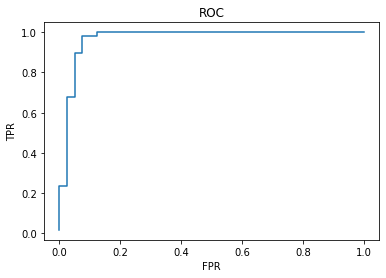

In [8]:
# equivalent algorithm to compute FPR, TPR, AUC and ROC curve:
def FPRTPRAUC(pred, y):
    sorted_pred_p = np.argsort(-pred.astype('float'))
    TPR = np.cumsum(y[sorted_pred_p]) / np.sum(y)
    FPR = np.cumsum(1 - y[sorted_pred_p]) / np.sum(1 - y)
    AUC = np.sum(np.diff(FPR, prepend = 0) * TPR)
    return FPR, TPR, AUC 

ROC_FPR, ROC_TPR, ROC_AUC = FPRTPRAUC(pred_p, data['target'][indices[M:]])
plt.plot(ROC_FPR, ROC_TPR) # plt.plot(np.sort(FPR),np.sort(TPR))
print('AUC = %.6f'%ROC_AUC)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## Generalized Linear Model

### Exponential Family

Let $\theta,\phi$ be parameters and define a distrbution with density
$$f_{\theta,\phi}(x) = \exp\{\frac{T(x)^T\eta(\theta)-\zeta(\eta(\theta))}{\phi} +h(y,\phi)\},$$
then we call $f_{\theta,\phi^2}$ an exponential family when varying $\theta$ and $\phi$. 

**Example** Gaussian distribution is an exponential family since $f_{\mu,\sigma^2}(x) = \exp\{\frac{-[x^2,x][\frac 12,-\mu]^T-\frac12\mu^2}{\sigma^2}-\ln \sqrt{2\pi\sigma^2}\}$ where $T(x) = [x^2,x]^T$ and $\eta(\mu)= [\frac12,-\mu]^T$.

### Generalized Linear Model

Suppose the response, $y$ follows an exponential family $f_{\theta,\phi}$ with unknown parameters $\theta,\phi$. We call that $f$ is a generalized linear model. 

Also, assume $g$ satisfies that $g(\mathbb E_{\theta,\phi}(y)) = T(x)^T\eta(\theta)$, then we call $g$ the link function.

**Example** For logistic regression, 
$y\sim\mathbb P(Y=1|x) = \exp\{-\ln (1+\exp\{-x^T\beta\})\}$ is genearlized linear model with unknown $\beta$. It has expectation $\mathbb E_\beta(y) = \exp\{-\ln (1+\exp\{-x^T\beta\})\}$. Thus, we have 
$$-\log \left(e^{-\log\mathbb E_\beta(y)}-1 \right)=x^T\beta,$$
indicating that the link function is given by $g(\mu) = -\log (e^{-\log \mu}-1) = \log (\mu/(1-\mu))$.